## Fish regression analysis



In [13]:
# imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats


from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



import statsmodels.api as sm

from sklearn.model_selection import train_test_split


In [14]:
# import dataset from gustavos github

username = "datagus"
repository = "ASDA2025"
directory = "datasets/Fish.csv"
github_url = f"https://raw.githubusercontent.com/{username}/{repository}/main/{directory}"
df = pd.read_csv(github_url)

## Descriptive Analysis and

In [15]:
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [16]:

print("=== Dataset Overview ===")
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])
print("\nColumn names:", list(df.columns))
print("\nDataFrame info:")
df.info()

=== Dataset Overview ===
Rows: 159
Columns: 7

Column names: ['Species', 'Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width']

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [17]:
structure = []

for col in df.columns:
    structure.append({
        "feature": col,
        "dtype": str(df[col].dtype),
        "description": "—",   # du füllst das später im Report
        "n_unique": df[col].nunique(),
        "example_values": df[col].unique()[:3]
    })

structure_df = pd.DataFrame(structure)
structure_df

,feature,dtype,description,n_unique,example_values
0,Species,object,—,7,"[Bream, Roach, Whitefish]"
1,Weight,float64,—,101,"[242.0, 290.0, 340.0]"
2,Length1,float64,—,116,"[23.2, 24.0, 23.9]"
3,Length2,float64,—,93,"[25.4, 26.3, 26.5]"
4,Length3,float64,—,124,"[30.0, 31.2, 31.1]"
5,Height,float64,—,154,"[11.52, 12.48, 12.3778]"
6,Width,float64,—,152,"[4.02, 4.3056, 4.6961]"


In [18]:
# Missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Duplicates
print("\nNumber of duplicated rows:", df.duplicated().sum())



Missing values per column:
Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

Number of duplicated rows: 0


In [19]:
# Descriptive statistics for numeric columns

print("\n=== Descriptive Statistics — Numeric Columns ===")
numeric_stats = df.describe().T
numeric_stats



=== Descriptive Statistics — Numeric Columns ===


,count,mean,std,min,25%,50%,75%,max
Weight,159.0,398.326415,357.978317,0.0000,120.00000,273.0000,650.0000,1650.000
Length1,159.0,26.247170,9.996441,7.5000,19.05000,25.2000,32.7000,59.000
Length2,159.0,28.415723,10.716328,8.4000,21.00000,27.3000,35.5000,63.400
Length3,159.0,31.227044,11.610246,8.8000,23.15000,29.4000,39.6500,68.000
Height,159.0,8.970994,4.286208,1.7284,5.94480,7.7860,12.3659,18.957
Width,159.0,4.417486,1.685804,1.0476,3.38565,4.2485,5.5845,8.142


In [20]:
# Descriptive statistics for categorical columns

categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print("\n=== Descriptive Statistics — Categorical Columns ===")

cat_stats = []
for col in categorical_cols:
    value_counts = df[col].value_counts()
    cat_stats.append({
        "column": col,
        "count": len(df[col]),
        "n_unique": df[col].nunique(),
        "most_frequent": value_counts.idxmax(),
        "most_frequent_count": value_counts.max(),
        "least_frequent": value_counts.idxmin(),
        "least_frequent_count": value_counts.min(),
    })

cat_stats_df = pd.DataFrame(cat_stats)
cat_stats_df


=== Descriptive Statistics — Categorical Columns ===


,column,count,n_unique,most_frequent,most_frequent_count,least_frequent,least_frequent_count
0,Species,159,7,Perch,56,Whitefish,6


## Check Asumptions and Preconditions

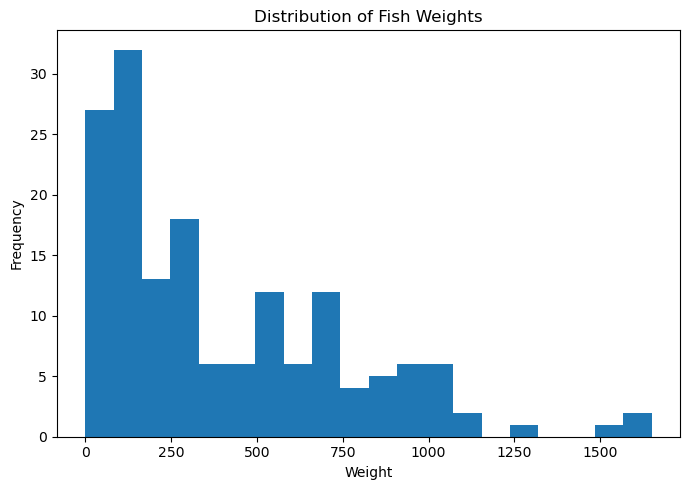

In [21]:
# Normal distribution of dependent variable

plt.figure(figsize=(7,5))
plt.hist(df["Weight"].dropna(), bins=20)
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.title("Distribution of Fish Weights")
plt.tight_layout()
plt.show()

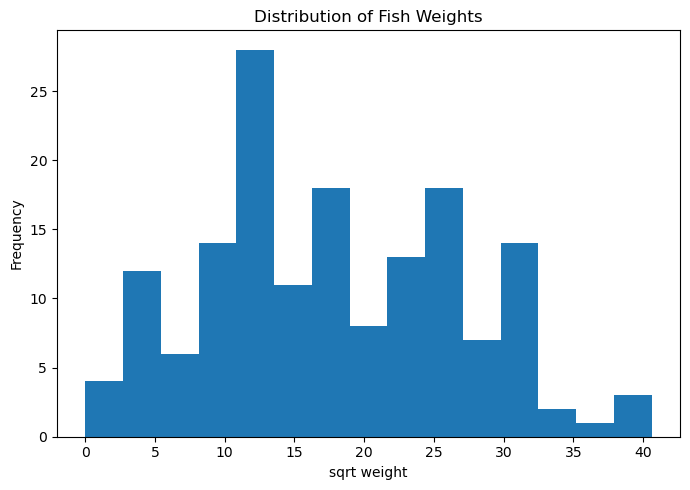

In [22]:
# log +1 transform the data to approach normality
df["sqrt_weight"] = np.sqrt(df["Weight"])

plt.figure(figsize=(7,5))
plt.hist(df["sqrt_weight"].dropna(), bins=15)
plt.xlabel("sqrt weight")
plt.ylabel("Frequency")
plt.title("Distribution of Fish Weights")
plt.tight_layout()
plt.show()

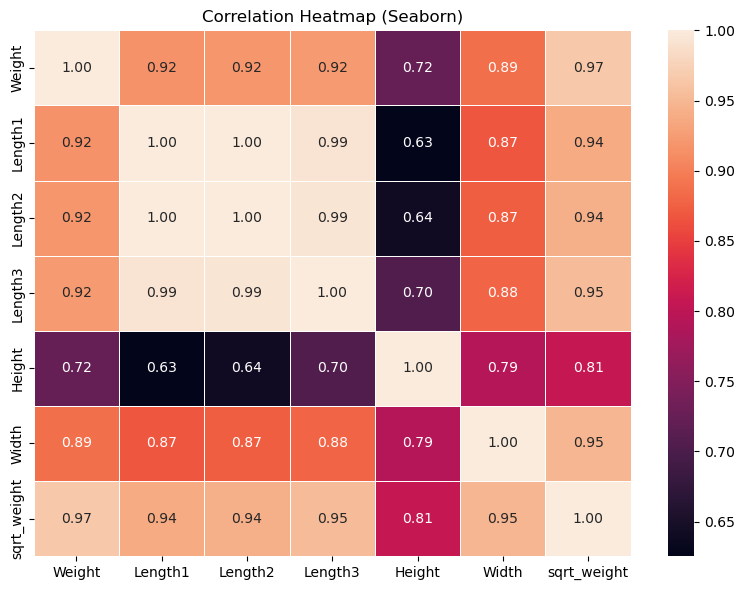

In [23]:
### Colinearity of Variables

# Compute correlation matrix
corr = df.corr(numeric_only=True)

# Plot using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap (Seaborn)")
plt.tight_layout()
plt.show()

High correlations between length1, lenght2, lenght3. We will drop lenght2 and lenght3 in the model to avoid multicolinearity.

In [24]:
# Prepare data in train dataset to fit the model (change categorical value (species) into numerical columns (one for each species))
df = pd.get_dummies(df, columns=["Species"], drop_first=False)


In [25]:
df.columns


Index(['Weight', 'Length1', 'Length2', 'Length3', 'Height', 'Width',
       'sqrt_weight', 'Species_Bream', 'Species_Parkki', 'Species_Perch',
       'Species_Pike', 'Species_Roach', 'Species_Smelt', 'Species_Whitefish'],
      dtype='object')

In [26]:
df.head()

,Weight,Length1,Length2,Length3,Height,Width,sqrt_weight,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
0,242.0,23.2,25.4,30.0,11.5200,4.0200,15.556349,True,False,False,False,False,False,False
1,290.0,24.0,26.3,31.2,12.4800,4.3056,17.029386,True,False,False,False,False,False,False
2,340.0,23.9,26.5,31.1,12.3778,4.6961,18.439089,True,False,False,False,False,False,False
3,363.0,26.3,29.0,33.5,12.7300,4.4555,19.052559,True,False,False,False,False,False,False
4,430.0,26.5,29.0,34.0,12.4440,5.1340,20.736441,True,False,False,False,False,False,False


In [27]:
# Select the three highly correlated columns
X = df[['Length1', 'Length2', 'Length3']]

# Add constant for VIF calculation
X_with_const = np.column_stack([np.ones(len(X)), X])

# Compute VIF
vif_values = [variance_inflation_factor(X_with_const, i) for i in range(1, X_with_const.shape[1])]

# Prepare results
vif_df = pd.DataFrame({
    "Variable": ["Length1", "Length2", "Length3"],
    "VIF": vif_values
})

vif_df

,Variable,VIF
0,Length1,1333.714722
1,Length2,1800.353105
2,Length3,109.468882


Use Lenght 2. It correlates highest with weight at 0.92 (all of them are close)

In [28]:
# Use sklearn to split the data

# Define target (y) and predictors (X)
y = df["sqrt_weight"]
X = df[["Length2", "Height", "Width", 'Species_Bream', 'Species_Parkki', 'Species_Perch',
       'Species_Pike', 'Species_Roach', 'Species_Smelt', 'Species_Whitefish']]   # example clean feature set

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% test data
    random_state=42,    # reproducible
)

print("Train rows:", len(X_train))
print("Test rows:", len(X_test))

Train rows: 127
Test rows: 32


In [29]:
# Train linear regression model on training data

# Create the model
model = LinearRegression()

# Train (fit) the model on the training data
model.fit(X_train, y_train)




LinearRegression()

In [30]:
print("Intercept:", model.intercept_)

coefficients = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model.coef_
})

coefficients

Intercept: -8.636557920004986


,Feature,Coefficient
0,Length2,0.628784
1,Height,0.259084
2,Width,1.388316
3,Species_Bream,0.507645
4,Species_Parkki,1.086819
5,Species_Perch,-0.012170
6,Species_Pike,-3.563412
7,Species_Roach,-0.498531
8,Species_Smelt,1.780368
9,Species_Whitefish,0.699281


In [31]:
# predict y from test data x

y_pred = model.predict(X_test)


In [32]:
# evaluation of model performance using different metrics
# careful: this is still on the sqrt transformed data

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R² Score:", r2)

RMSE: 1.0504158743344683
MAE: 0.7969930504085094
R² Score: 0.988995225828123


In [33]:
# invert the sqrt transformation to get real weight predictions

y_pred_inverted = y_pred ** 2

y_test_inverted = y_test ** 2


In [34]:
mse = mean_squared_error(y_test_inverted, y_pred_inverted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inverted, y_pred_inverted)
r2 = r2_score(y_test_inverted, y_pred_inverted)
mape = np.mean(np.abs((y_test_inverted - y_pred_inverted) / y_test_inverted)) * 100


print("RMSE:", rmse)
print("MAE:", mae)
print("R² Score:", r2)
print("MAPE:", mape)

RMSE: 54.61517310230511
MAE: 34.881085809748846
R² Score: 0.9790295831809449
MAPE: 11.981050033552467


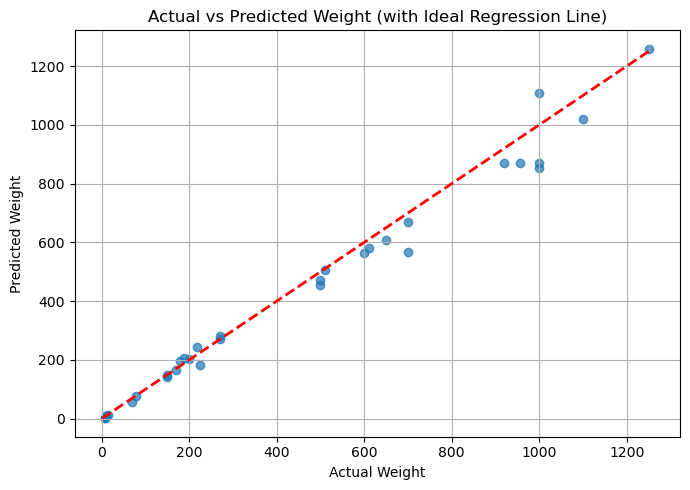

In [35]:
# Plot Actual vs Predicted with regression line

plt.figure(figsize=(7,5))

# Scatter of true vs predicted
plt.scatter(y_test_inverted, y_pred_inverted, alpha=0.7)

# Regression line (perfect predictions)
min_val = min(y_test_inverted.min(), y_pred_inverted.min())
max_val = max(y_test_inverted.max(), y_pred_inverted.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

plt.xlabel("Actual Weight")
plt.ylabel("Predicted Weight")
plt.title("Actual vs Predicted Weight (with Ideal Regression Line)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# check normal distribution of residuals

# Residuals in transformed (sqrt) space – relevant for normality assumption
residuals_sqrt = y_test - y_pred

# Residuals in original weight space (for intuition)
residuals_weight = y_test_inverted - y_pred_inverted

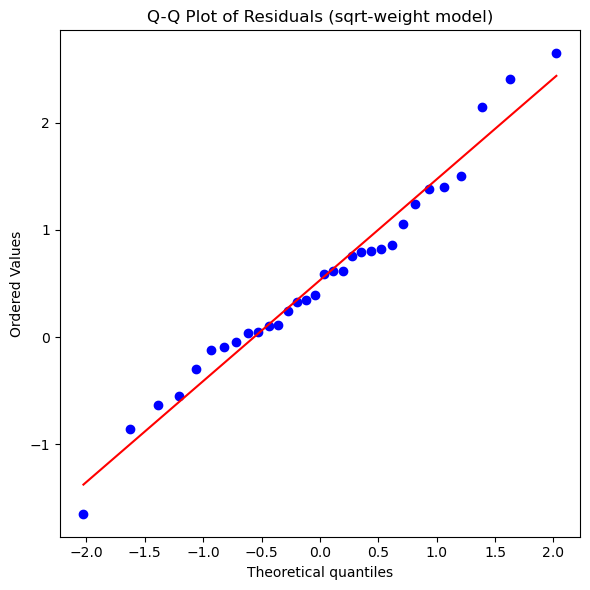

In [37]:
plt.figure(figsize=(6,6))
stats.probplot(residuals_sqrt, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (sqrt-weight model)")
plt.tight_layout()
plt.show()

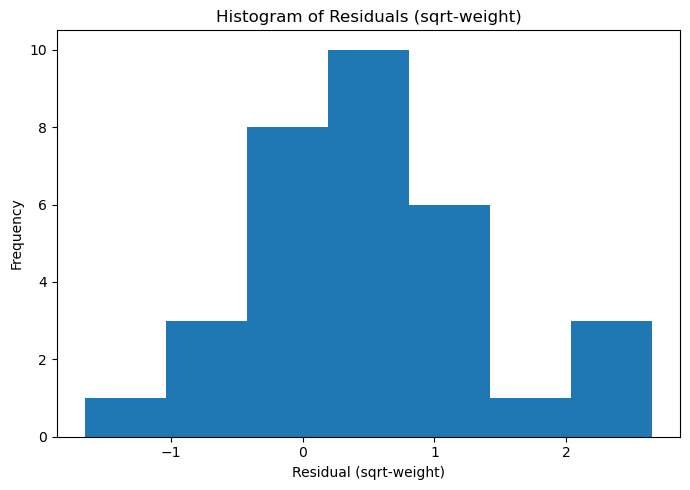

In [38]:
# histogram of residuals

plt.figure(figsize=(7,5))
plt.hist(residuals_sqrt, bins=7)
plt.xlabel("Residual (sqrt-weight)")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals (sqrt-weight)")
plt.tight_layout()
plt.show()